# ELISA Concentration computation with Linear curve

This notebook computes the parameters for a linear standard curve.\
It will also calculate concentration values for the sample values and save them in a predefined directory as a new excel file.\
As input a platereader excel file of an ELISA measurement (or other measurements in a 96 well format) is used.\
Standard values have to be part of the plate and will be used for the computation of the standard curve.

<span style="color:red"> Everything that needs to be filled out / should be interacted with is indicated in red.
    
    
    
**Attention: Highest standard values will be removed in case R squared is not below 0.9! To check how many of your standard values were not used in the computation of the standard curve, check section "Standard curve"**

### Importing relevant libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
import os
import datetime

# <span style="color:red"> Please enter info about your ELISA here:

- Fill out either A) or B) and skip the other one.
- If a standard curve without a serial dilution is used, make sure that the dilution factor in A) is set to 0.
- Fill out C in any case.

##### <span style="color:red"> A) FILL OUT WHEN THERE IS A SERIAL DILUTION FOR THE STANDARD 

In [2]:
# 1. Adjust value to wanted value
highest_standard_concentration = 100000 

# 2. Dilution factor in between standard values (e.g. 2 = dilution of 1:2 in between standard values)
dilution_factor = 2

# 3. Number of standard values
number_of_st_values = 12

#####  <span style="color:red">B) FILL OUT FOR CUSTOM STANDARD CONCENTRATIONS

In [3]:
# 1. Please check if dilution_factor = 0 in A) otherwise please set it to 0.

# 2. Pass standard concentrations in a list in decending order (like the example below)

st_concentration_list = [5, 3, 2, 1, 0.5, 0.25] 

##### <span style="color:red"> C) ALWAYS FILL OUT

##### Please read if you use this notebook for the first time:
Notes about filling out "C":
1. **Directory path to your excel file along with filename.xlsx** \
Example: r"R:\example_folder_1\example_folder_2\ELISA\Sample_file.xlsx" \
    <span style="color:red"> *The little "r" in the front is important!*


2. **Protein to detect** \
For example IFNy, IL2, IgG...


3. **Concentration dimension**\
Unit, like nmol/ml or pg/µl...


4. **Start of your 96 well plate**\
Take a look at the graphic + explantation below if you don't know what to insert here


5. **ODs measured for standard values**\
Example : st_ODs = [3.0768, 2.9526, 2.068, 1.0887, 0.5681, 0.2883, 0.1667, 0.0989, 0.0706, 0.0631, 0.0466, 0.0367]


6. **Directory where you want to store your result**\
Example: output_directory = r"C:\Users\YourUsername\Desktop\ELISA results"\
Note: If you specify a directory that doesn't exist yet it will be created!\
You can just use the examplary path from above, change "YourUsername" to your PC Username and the folder ELISA results\
will be created on your desktop.\
    <span style="color:red">*Please use the small "r" again in front of your directory name!*

In [4]:
# 1. Directory path to your excel file along with filename.xlsx 
file_directory = r"Sample file.xlsx"

# 2. Protein to detect
protein = "test"

# 3. Concentration dimension
dimension = "pg/ml"

# 4. Start of your 96 well plate: 
start_row = 68

# 5. ODs measured for standard values
st_ODs = 0

    # alternatively set the list to 0 (st_ODs = 0) and pass the row name where your standard is pipetted 
    # (only applicable if all 12 values are filled) 
    
st_OD_row = "H"

# 6. Directory where you want to store your result
output_directory = r"C:\Users\Tina\Desktop\ELISA results"

Take a look at your ELISA excel file.\
Write down the row where the 96 well plate values you want to detect starts.\
In this example it would be "68":

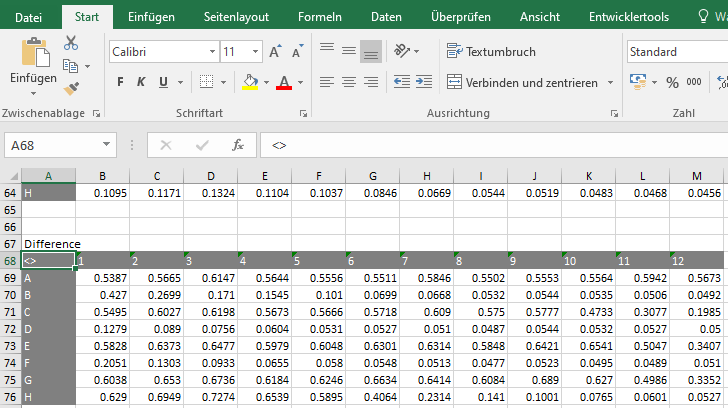

# <span style="color:red"> Please confirm your data

In [5]:
# importing the respective excel file
df = pd.read_excel(f"{file_directory}", header = None)

# extract the data from specific cells
cell_data = df.iloc[start_row:(start_row + 8), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

cell_data["row_names"] = ["A", "B", "C", "D", "E", "F", "G", "H"]

cell_data = cell_data.set_index("row_names")

print("Check if this is your raw data:")
cell_data.head(10)

Check if this is your raw data:


,1,2,3,4,5,6,7,8,9,10,11,12
row_names,,,,,,,,,,,,
A,0.5387,0.5665,0.6147,0.5644,0.5556,0.5511,0.5846,0.5502,0.5553,0.5564,0.5942,0.5673
B,0.427,0.2699,0.1710,0.1545,0.101,0.0699,0.0668,0.0532,0.0544,0.0535,0.0506,0.0492
C,0.5495,0.6027,0.6198,0.5673,0.5666,0.5718,0.6090,0.5750,0.5777,0.4733,0.3077,0.1985
D,0.1279,0.0890,0.0756,0.0604,0.0531,0.0527,0.0510,0.0487,0.0544,0.0532,0.0527,0.0500
E,0.5828,0.6373,0.6477,0.5979,0.6048,0.6301,0.6314,0.5848,0.6421,0.6541,0.5047,0.3407
F,0.2051,0.1303,0.0933,0.0655,0.058,0.0548,0.0513,0.0477,0.0523,0.0495,0.0489,0.0510
G,0.6038,0.6530,0.6736,0.6184,0.6246,0.6634,0.6414,0.6084,0.6890,0.6270,0.4986,0.3352
H,0.629,0.6949,0.7274,0.6539,0.5895,0.4064,0.2314,0.1410,0.1001,0.0765,0.0601,0.0527


In [6]:
if st_ODs == 0:
    alternative_st_ODs = cell_data.loc[st_OD_row]
    print("Check if these are your standard values:\n", alternative_st_ODs)
else:
        print("Check if these are your standard values: \n", st_ODs)
    

Check if these are your standard values:
 1      0.629
2     0.6949
3     0.7274
4     0.6539
5     0.5895
6     0.4064
7     0.2314
8      0.141
9     0.1001
10    0.0765
11    0.0601
12    0.0527
Name: H, dtype: object


### Computation of standard values

In [7]:
current_standard = highest_standard_concentration    # highest standard concentration
st_values = []                                       # list of standard concentrations

if dilution_factor == 0:
    st_values = st_concentration_list
else: 
    for i in range(number_of_st_values):
        if len(st_values) == 0:
            st_values.append(current_standard)
        else: 
            st_values.append(current_standard/dilution_factor)
            current_standard = current_standard/dilution_factor   

In [8]:
print(f"Standard concentrations used: \n{st_values}")

Standard concentrations used: 
[100000, 50000.0, 25000.0, 12500.0, 6250.0, 3125.0, 1562.5, 781.25, 390.625, 195.3125, 97.65625, 48.828125]


### Curve fitting

In [9]:
# Using standard concentrations as x-values
x = np.array(st_values)  

# ODs of standard curve for y-values
if st_ODs == 0:
    st_ODs = list(alternative_st_ODs)
    
y = np.array(st_ODs)  

def linear_curve(x, m, t):
    '''Determines the "y" variable by inserting the already determined x, m, t parameters of a linear curve.
    
    args:
    x = list / array of standard concentration values
    m = slope
    t = y axis intersect
    
    returns:
    computed concentration value (y)
    '''
    return m * x + t

# Computation of parameters m, t with the help of x and y standard values
parameters_optimal, parameters_cov = optimize.curve_fit(linear_curve, x, y, p0=[1, 0]) #cov = covariance; p0 = initial values for curve fit

# slope
m = parameters_optimal[0]

# y axis intersect
t = parameters_optimal[1]

# Compute R squared value
y_predicted = linear_curve(x, m, t)
r_squared = r2_score(y, y_predicted)

# Removing highest standard values and refitting curve, if r_squared is too low

number_of_removed_values = 0

while r_squared < 0.9:
    x = x[1:]
    y = y[1:]
    parameters_optimal, parameters_cov = optimize.curve_fit(linear_curve, x, y, p0=[1, 0])
    # slope
    m = parameters_optimal[0]

    # y axis intersect
    t = parameters_optimal[1]
    
    # Compute R squared value
    y_predicted = linear_curve(x, m, t)
    r_squared = r2_score(y, y_predicted)
    
    number_of_removed_values = number_of_removed_values + 1
    
# Used to model standard curve
x_model = np.linspace(min(x), max(x)+100, 1000) 
y_model = linear_curve(x_model, m, t) 

### Standard curve

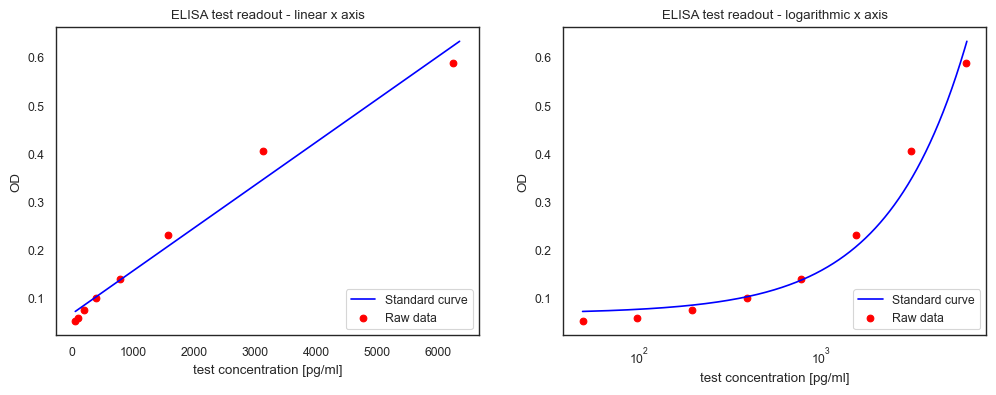

Standard curve parameters:
m = 8.893646464181484e-05  slope 
t =  0.06879209901569293  y axis intersect
R squared = 0.9766360989347427
Number of standard values not used (removed the highest standard concentration values) : 4


In [12]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.set_style("white")
sns.set_context("paper")

# Plot in the first subplot with a linear x-axis
axes[0].plot(x_model, y_model, label="Standard curve", color="blue")
axes[0].scatter(x, y, color="red", label="Raw data")
axes[0].set_title(f"ELISA {protein} readout - linear x axis")
axes[0].set_xlabel(f"{protein} concentration [{dimension}]")
axes[0].set_ylabel("OD")
axes[0].legend(loc="lower right")


# Plot in the second subplot with a logarithmic x-axis
axes[1].plot(x_model, y_model, label="Standard curve", color="blue")
axes[1].scatter(x, y, color="red", label="Raw data")
axes[1].set_title(f"ELISA {protein} readout - logarithmic x axis")
axes[1].set_xlabel(f"{protein} concentration [{dimension}]")
axes[1].set_ylabel("OD")
axes[1].set_xscale("log")
axes[1].legend(loc="lower right")

# Show the plots
plt.show()

# Print curve parameters and R squared
print("Standard curve parameters:\nm =", m, " slope", 
      "\nt = ", t, " y axis intersect") 

print(f"R squared = {r_squared}")
print(f"Number of standard values not used (removed the highest standard concentration values) : {number_of_removed_values}")

Note that both graphs show the same values. The only difference is the representation:\
x-axis linear vs x-axis logarithmic

# Determination of sample concentrations

In [ ]:
def OD_to_concentration(y, m=m, t=t):
    ''' Will compute x value (= concentration) from y value (= OD). 
    Global variables m and t are accessed from the previously computed linear standard curve.
    Alternatively parameters can be passed manually.
    
    args:
    y = OD
    m = slope
    t = y axis intersect
    
    returns:
    concentration value (x)
    '''
    x = (y-t)/m
    
    return x

# Example with OD = 0.3:
y = 0.6038
x = OD_to_concentration(y)

print(x)

In [ ]:
for index, row in cell_data.iterrows():
    cell_data.loc[index] = pd.to_numeric(row, errors='coerce')

output = cell_data.applymap(OD_to_concentration)

In [ ]:
# Rounding values to 2 digits after comma
output = output.applymap(lambda x: round(x, 2))

print("Determined concentrations:")
output.head(12)

Here are your original OD-values and the limit values to check again:

In [ ]:
print("Original values:")

cell_data.head(12)

# Transfering outcomes to excel file

In [ ]:
current_date = datetime.date.today() 
date_str = current_date.strftime("%Y-%m-%d")

if not os.path.exists(output_directory):
    try:
        os.makedirs(output_directory)
    except OSError as e:
        print(f"Error creating the directory: {e}")
    else:
        print(f"Directory '{output_directory}' created successfully")
  
file_name = os.path.join(output_directory, f"{date_str}.xlsx")
output.to_excel(file_name)

You're done! Your data was saved to the previously specified directory. \
Please save a screenshot of your standard curve (under "Standard curve") and your curve parameters if needed.